# Exploratory Data Analysis

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Import the dataset as a CSV
df = pd.read_csv('0_churn_dataset.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,NE,64,408,No,No,0,261.9,113,44.52,148.1,99,12.59,145.2,74,6.53,13.8,4,3.73,0,False
1,TX,139,510,Yes,Yes,31,203.5,82,34.60,200.3,72,17.03,214.0,112,9.63,13.4,6,3.62,1,True
2,VT,93,510,No,No,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,False
3,GA,136,415,No,No,0,163.4,83,27.78,249.3,119,21.19,249.7,90,11.24,9.8,4,2.65,7,False
4,IL,16,415,Yes,No,0,110.0,91,18.70,147.3,75,12.52,190.5,73,8.57,6.4,7,1.73,0,False


In [2]:
# Show summary statistics for all columns
df.describe()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000
mean,101.348449,436.735245,8.194065,179.796132,100.572858,30.565895,201.225375,100.136379,17.104365,201.064688,100.077026,9.048006,10.209003,4.474825,2.756939,1.566522
std,39.741765,42.112741,13.731450,54.313911,20.100779,9.233338,50.952796,20.076914,4.330967,50.610602,19.485898,2.277532,2.772336,2.471441,0.748525,1.327655
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,88.000000,24.430000,166.550000,87.000000,14.155000,167.250000,87.000000,7.525000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.300000,101.000000,30.480000,201.800000,101.000000,17.150000,201.600000,100.000000,9.070000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,415.000000,20.000000,216.850000,114.000000,36.865000,235.450000,114.000000,20.015000,235.300000,113.000000,10.590000,12.000000,6.000000,3.240000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,18.900000,20.000000,5.100000,9.000000


In [3]:
# check for null values
df.isnull().sum()
# no null values, so no need to drop any rows

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [4]:
# check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of Duplicate Rows:{duplicates}")
# no duplicate rows, so no need to drop any rows

Number of Duplicate Rows:0


In [5]:
#Check variables and associated data type
df.dtypes
# Looks fine as well

State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [6]:
# Insight 1: Finding out proportion of customers who have churned in total
total_churned = df['Churn'].sum()
total_customers = df.shape[0]
proportion = (total_churned / total_customers) * 100
print(f"Insight 1: {proportion}% of customers have churned in total")

Insight 1: 14.50483494498166% of customers have churned in total


This means the dataset is unbalanced and we need to be careful building the model so it can predict both churners and non-churners well

In [7]:
# Insight 2: Finding out if churned customers have higher customer service calls than non-churned customers
non_churned = df[df['Churn'] == False]
churned = df[df['Churn'] == True]

avg_service_calls_churned = churned['Customer service calls'].mean()
avg_service_calls_non_churned = non_churned['Customer service calls'].mean()

print(f"Average customer service calls for churned customers: {avg_service_calls_churned}")
print(f"Average customer service calls for non-churned customers: {avg_service_calls_non_churned}")

if avg_service_calls_churned > avg_service_calls_non_churned:
    print("Insight 2: Churned customers have higher average nr. of customer service calls than non-churned customers.")
else:
    print("Insight 2: Churned customers do not have higher average nr. of customer service calls than non-churned customers.")


Average customer service calls for churned customers: 2.2666666666666666
Average customer service calls for non-churned customers: 1.4477379095163807
Insight 2: Churned customers have higher average nr. of customer service calls than non-churned customers.


In [8]:
#Insight 3: Find out if customers who were charged more than the average monthly charge are more likely to churn
# Adding column that sums up total day charge, total eve charge, total night charge and total intl charge
insight_3_df = df.copy()
insight_3_df['Total charge'] = insight_3_df['Total day charge'] + insight_3_df['Total eve charge'] + insight_3_df['Total night charge'] + insight_3_df['Total intl charge']
insight_3_df["Total charge"].describe()

count    2999.000000
mean       59.475205
std        10.446254
min        22.930000
25%        52.460000
50%        59.510000
75%        66.475000
max        96.150000
Name: Total charge, dtype: float64

In [9]:
# Calculating likelihood of churn for customers who were charged more than the average monthly charge
# Calculate average charge
avg_charge = insight_3_df['Total charge'].mean()
# Extracting churned customers who were charged more than the average monthly charge
churned_above_avg_charge = insight_3_df[insight_3_df['Total charge'] > avg_charge]
churned_above_avg_charge.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,...,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,Total charge
0,NE,64,408,No,No,0,261.9,113,44.52,148.1,...,12.59,145.2,74,6.53,13.8,4,3.73,0,False,67.37
1,TX,139,510,Yes,Yes,31,203.5,82,34.60,200.3,...,17.03,214.0,112,9.63,13.4,6,3.62,1,True,64.88
3,GA,136,415,No,No,0,163.4,83,27.78,249.3,...,21.19,249.7,90,11.24,9.8,4,2.65,7,False,62.86
7,TN,47,415,No,Yes,30,196.6,93,33.42,241.4,...,20.52,226.0,118,10.17,12.9,4,3.48,2,False,67.59
8,NE,73,415,No,No,0,198.3,94,33.71,279.3,...,23.74,146.2,87,6.58,14.8,8,4.00,3,False,68.03


In [10]:
# Calculate churn rate for customers who were charged more than the average monthly charge
churn_rate_above_avg_charge = churned_above_avg_charge['Churn'].mean() * 100
print(f"The churn rate for customers who were charged more than the average monthly charge is {churn_rate_above_avg_charge:.2f}%")
#Calculate average churn rate for all customers
avg_churn_rate = insight_3_df['Churn'].mean() * 100
print(f"The average churn rate for all customers is {avg_churn_rate:.2f}%")
print(f"Insight 3: Customers who were charged more than the average monthly charge are more likely to churn than the average customer")

The churn rate for customers who were charged more than the average monthly charge is 17.15%
The average churn rate for all customers is 14.50%
Insight 3: Customers who were charged more than the average monthly charge are more likely to churn than the average customer


# End-to-end machine learning pipeline

## Evaluation Metric

This is a classification problem because the target variable/label "Churn" is a binary variable that takes on one of two possible values, namely "True" or "False". Following, two different machine learning models will be trained to achieve as high of a weighted accuracy as possible.

Expected Cost, also called Cost-sensitive classification is chosen as the evaluation metric because research suggests acquiring new clients costs five to six times more than retaining existing customers (Verbeke et al., 2012). Therefore, if cost reduction is the goal, incorrectly predicting a churning customer to not churn (false negative) should be penalized five to six times more heavily than incorrectly predicting a non-churning customer to churn (false positive). We can therefore specify the cost with a function:

**Total Cost**
$$
\text{Total Cost} = (C_{FP} \times \text{FP}) + (C_{FN} \times \text{FN}) + (C_{TP} \times \text{TP}) + (C_{TN} \times \text{TN})
$$

where:
- $ C_{FP} $ = Cost of a False Positive = 1 because the company will spend money for retention of this customer and equalling it to 1 will allow for easy scaling for the False Negative scenario.
- $ \text{FP} $ = Number of False Positives 
- $ C_{FN} $ = Cost of a False Negative = 5.5 because the client will churn and acquiring a new client will cost 5-6 times as much as retention would have cost.
- $ \text{FN} $ = Number of False Negatives
- $ C_{TP} $ = Cost of a True Positive = 1 because the company will still spend money for retention of this customer.
- $ \text{TP} $ = Number of True Positives
- $ C_{TN} $ = Cost of a True Negative = 0 because the company will not spend any money on this customer and they will not churn.
- $ \text{TN} $ = Number of True Negatives

, so: 
$$
\text{Total Cost} = (1 \times \text{FP}) + (5.5 \times \text{FN}) + (1 \times \text{TP}) + \cancel{(0 \times \text{TN})}
$$

We now train two machine learning models to minimize this total cost function
However, first, to ensure our model provides value, we calculate costs for two baseline scenarios. We want the models to perform better than these (i.e. have lower costs):
- Baseline scenario 1: every customer is retained
- Baseline scenario 2: no customer is retained

To avoid code redundancy, before these baseline scenarios, we additionally code up the total cost function

Therefore, we proceed as follows:
1. Define the cost matrix and a function to calculate the total cost
2. Calculate the costs of both baseline models
3. Build the two machine learning models

In [11]:
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score

# Define cost matrix
cost_matrix = np.array([
    [0, 1],    # Costs for actual class 0 (TN=0, FP=1)
    [5.5, 1]   # Costs for actual class 1 (FN=5.5, TP=1)
])
print("Global cost_matrix defined.")

Global cost_matrix defined.


In [12]:
# Define cost function based on the cost matrix
def total_cost_scorer(y_true, y_pred, cost_matrix):
    """
    Global custom scoring function to calculate the total cost.
    Uses the globally defined cost_matrix.
    """
    # Use labels=[0, 1] to ensure consistent order
    # Handle cases where y_pred might not contain both classes
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    except ValueError: # Handle cases with only one class predicted/present
         if np.all(y_true == 0) and np.all(y_pred == 0): tn, fp, fn, tp = len(y_true), 0, 0, 0
         elif np.all(y_true == 1) and np.all(y_pred == 1): tn, fp, fn, tp = 0, 0, 0, len(y_true)
         elif np.all(y_true == 0) and np.all(y_pred == 1): tn, fp, fn, tp = 0, len(y_true), 0, 0
         elif np.all(y_true == 1) and np.all(y_pred == 0): tn, fp, fn, tp = 0, 0, len(y_true), 0
         else: # raise error telling user that the confusion matrix is not properly defined or there are no predictions
             raise ValueError("Confusion matrix is not properly defined or there are no predictions. Please check your inputs.") 
             
    # Calculate total cost using the global cost_matrix
    total_cost = (fp * cost_matrix[0, 1]) + (fn * cost_matrix[1, 0]) + (tp * cost_matrix[1, 1]) + (tn * cost_matrix[0, 0])
    return total_cost

# Create the global scorer object for cost (used later for training the models)
cost_function_scorer = make_scorer(total_cost_scorer, greater_is_better=False)
print("Global total_cost_scorer and cost_function_scorer defined.")

Global total_cost_scorer and cost_function_scorer defined.


## Baseline scenarios

### Baseline Scenario 1: Every customer is retained

##### Step 1: Train-test split

In [13]:
# Calculate total cost of baseline scenario 1
# First, need to get a training and test set to evaluate the model
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Churn'])
y = df['Churn']

# Splitting the data into training and test sets and stratifying by the target variable
# This ensures that the proportion of churned and non-churned customers is the same in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the nr of rows and columns of the train and test sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check the distribution of the target variable in train and test sets to ensure that stratify=y worked
print(f"Churn rate in training set: {y_train.mean() * 100:.2f}%")
print(f"Churn rate in test set: {y_test.mean() * 100:.2f}%")

# Add back in the target variable to the test set
baseline_1_df = X_test.copy()
baseline_1_df['Actual_Churn'] = y_test.values

# Create a dataframe with the test data and predicting every customer will churn
baseline_1_df['Predicted_Churn'] = 1  # Predicting all customers will churn

# Convert the actual_churn column to integer values (0 and 1)
baseline_1_df['Actual_Churn'] = baseline_1_df['Actual_Churn'].astype(int)

# Show the first few rows of the baseline dataframe
baseline_1_df.head()

X_train shape: (2399, 19)
X_test shape: (600, 19)
y_train shape: (2399,)
y_test shape: (600,)
Churn rate in training set: 14.51%
Churn rate in test set: 14.50%


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,...,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Actual_Churn,Predicted_Churn
694,KS,132,415,No,No,0,83.4,110,14.18,232.2,...,19.74,146.7,114,6.60,7.6,5,2.05,1,0,1
2644,IL,31,415,No,Yes,28,210.5,101,35.79,250.5,...,21.29,241.6,125,10.87,11.5,2,3.11,1,0,1
596,MA,80,408,No,No,0,148.6,106,25.26,210.8,...,17.92,203.7,86,9.17,10.0,2,2.70,2,0,1
2423,UT,95,415,No,No,0,157.9,103,26.84,259.6,...,22.07,230.0,117,10.35,14.0,2,3.78,0,0,1
1389,MN,115,415,No,No,0,200.2,92,34.03,244.9,...,20.82,190.9,96,8.59,8.8,3,2.38,1,0,1


#### Step 2: Calculate total cost

In [14]:
# Use the total_cost_scorer function to calculate the total cost of this baseline scenario
def calculate_baseline_cost(df):
    """
    Function to calculate the total cost of the baseline scenario.
    """
    # Calculate the total cost using the global scorer function
    total_cost = total_cost_scorer(y_test, df['Predicted_Churn'], cost_matrix)
    return total_cost

baseline_1_cost = calculate_baseline_cost(baseline_1_df)
print(f"Total cost of baseline scenario 1 (predicting all customers will churn): {baseline_1_cost:.2f}")

Total cost of baseline scenario 1 (predicting all customers will churn): 600.00


Therefore, the first baseline scenario costs **600 units**. 

Breaking down this cost, there are 600 customers in the train set.

Predicting all these customer will churn will lead to a cost of 1 per customer, regardless of a true positive or a false positive.

This results in a total cost of 600 * 1 = **600 units**.

### Baseline Scenario 2: No customer is retained

In [15]:
# Copy the baseline_1_df DataFrame to baseline_2_df
baseline_2_df = baseline_1_df.copy()
# Change the predicted churn values to 0 (No Churn) for all customers
baseline_2_df['Predicted_Churn'] = 0  # Predicting all customers will not churn
# Show the first few rows of the baseline_2_df DataFrame
baseline_2_df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,...,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Actual_Churn,Predicted_Churn
694,KS,132,415,No,No,0,83.4,110,14.18,232.2,...,19.74,146.7,114,6.60,7.6,5,2.05,1,0,0
2644,IL,31,415,No,Yes,28,210.5,101,35.79,250.5,...,21.29,241.6,125,10.87,11.5,2,3.11,1,0,0
596,MA,80,408,No,No,0,148.6,106,25.26,210.8,...,17.92,203.7,86,9.17,10.0,2,2.70,2,0,0
2423,UT,95,415,No,No,0,157.9,103,26.84,259.6,...,22.07,230.0,117,10.35,14.0,2,3.78,0,0,0
1389,MN,115,415,No,No,0,200.2,92,34.03,244.9,...,20.82,190.9,96,8.59,8.8,3,2.38,1,0,0


In [16]:
# Use the calculate_baseline_cost function to calculate the total cost of the 
# baseline scenario where all customers are predicted to not churn
total_cost_baseline_2 = calculate_baseline_cost(baseline_2_df)
print(f"Total cost of baseline scenario 2 (predicting all customers will not churn): {total_cost_baseline_2:.2f}")

Total cost of baseline scenario 2 (predicting all customers will not churn): 478.50


Therefore, the second baseline scenario costs **478.5 units**. 

Breaking down this cost, this scenario will correctly predict all non-churners and incur no cost for retaining them.

On the other hand, it will incorrectly predict the 14.5% of the customers in the train that are churners to not churn.

This represents 600 * 0.145 = 87 customers. 

For these 87 customers, incorrectly predicting no churn will lead to a cost of 5.5 per customer 

This results in a total cost of 87 * 5.5 = **478.5 units**.

#### Evaluating baseline scenarios

As visible, predicting all customers will not churn (baseline scenario 2) is cheaper than predicting all customers will churn (baseline scenario 1) for the test dataset with a cost of 478.5 units compared to 600 units.

Therefore, any model developed must achieve a lower total cost than 478.5 units to be considered valuable.

| Model                                 | Total Cost | Cost Reduction (vs Baseline Scenario 1) |
|---------------------------------------|------------|-----------------------------------------|
| Scenario 1: Retain every customer     | 600.0      | 0.0%                                    |
| **Scenario 2: Retain no customer**    | **478.5**  | **20.3%**                               |

## Machine Learning Models

### Model 1: Logistic Regression

This model is chosen because Logistic regression is a simple classification algorithm that can predict the probability of a binary response belonging to one class or the other. This is exactly the kind of prediction problem we have for our dataset where we predict if a customer churns or not.

#### Step 1: Feature Selection

In [17]:
# Model 1: Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Selection
# Drop state column as it is a categorical variable with too many options to be included in the model
model1_df = df.drop('State', axis=1)
# Make categorical columns International Plan and Voice Mail Plan into binary columns with 1 for Yes and 0 for No, do the same for Churn
model1_df['International plan'] = model1_df['International plan'].map({'Yes': 1, 'No': 0})
model1_df['Voice mail plan'] = model1_df['Voice mail plan'].map({'Yes': 1, 'No': 0})
model1_df['Churn'] = model1_df['Churn'].astype(int)
model1_df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,64,408,0,0,0,261.9,113,44.52,148.1,99,12.59,145.2,74,6.53,13.8,4,3.73,0,0
1,139,510,1,1,31,203.5,82,34.60,200.3,72,17.03,214.0,112,9.63,13.4,6,3.62,1,1
2,93,510,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,0
3,136,415,0,0,0,163.4,83,27.78,249.3,119,21.19,249.7,90,11.24,9.8,4,2.65,7,0
4,16,415,1,0,0,110.0,91,18.70,147.3,75,12.52,190.5,73,8.57,6.4,7,1.73,0,0


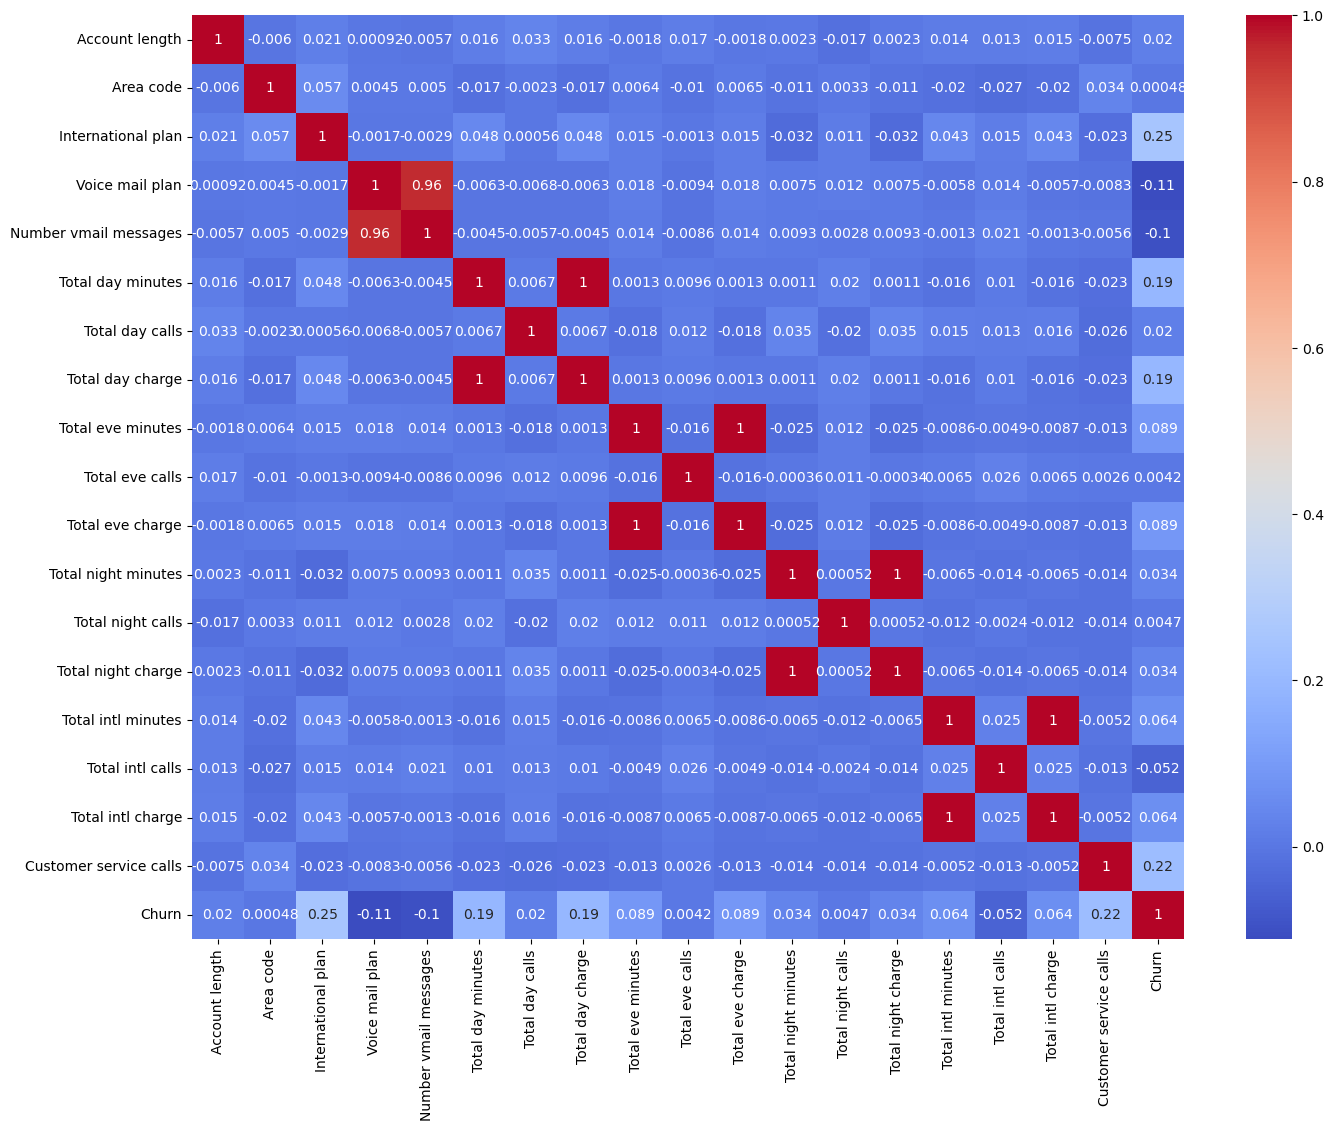

In [18]:
# Look at the correlation matrix to see which variables are correlated with Churn and should be included in the model
plt.figure(figsize=(16, 12))
sns.heatmap(model1_df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [19]:
# As total eve calls is perfectly correlated with total eve charge and total eve minutes, we will drop total eve calls and total eve minutes to avoid multicollinearity
model1_df = model1_df.drop(['Total eve calls', 'Total eve minutes'], axis=1)
# Do the same for total day calls and total day minutes, total night calls and total night minutes as well as total intl calls and total intl minutes
model1_df = model1_df.drop(['Total day calls', 'Total day minutes', 'Total night calls', 'Total night minutes', 'Total intl calls', 'Total intl minutes'], axis=1)
# Also drop area code column as it barely correlates with churn and should also be categorical, not numerical
model1_df = model1_df.drop('Area code', axis=1)
model1_df.head()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Churn
0,64,0,0,0,44.52,12.59,6.53,3.73,0,0
1,139,1,1,31,34.60,17.03,9.63,3.62,1,1
2,93,0,0,0,32.42,18.55,5.83,2.19,3,0
3,136,0,0,0,27.78,21.19,11.24,2.65,7,0
4,16,1,0,0,18.70,12.52,8.57,1.73,0,0


In [20]:
# As Number vmail messages is very highly correlated with Voice mail plan_Yes and Number vmail messages contains
# more information, we will drop Voice mail plan_Yes to avoid multicollinearity
model1_df = model1_df.drop(['Voice mail plan'], axis=1)
model1_df.head()

,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Churn
0,64,0,0,44.52,12.59,6.53,3.73,0,0
1,139,1,31,34.60,17.03,9.63,3.62,1,1
2,93,0,0,32.42,18.55,5.83,2.19,3,0
3,136,0,0,27.78,21.19,11.24,2.65,7,0
4,16,1,0,18.70,12.52,8.57,1.73,0,0


In [21]:
# Creating a descriptive table with min, median, mean, max values for the numerical columns
model1_df.describe()

,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Churn
count,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000
mean,101.348449,0.096032,8.194065,30.565895,17.104365,9.048006,2.756939,1.566522,0.145048
std,39.741765,0.294684,13.731450,9.233338,4.330967,2.277532,0.748525,1.327655,0.352208
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.040000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,0.000000,24.430000,14.155000,7.525000,2.300000,1.000000,0.000000
50%,101.000000,0.000000,0.000000,30.480000,17.150000,9.070000,2.780000,1.000000,0.000000
75%,127.000000,0.000000,20.000000,36.865000,20.015000,10.590000,3.240000,2.000000,0.000000
max,243.000000,1.000000,51.000000,59.640000,30.910000,17.770000,5.100000,9.000000,1.000000


#### Step 2: Train-test split

In [22]:
# Splitting the data into training and testing sets (80/20 split)
X = model1_df.drop(['Churn'], axis=1)  # Features
y = model1_df['Churn']  # Target variable

# Using stratify=y to ensure that the train and test sets have approximately the same proportion of churn instances
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the nr of rows and columns of the train and test sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check the distribution of the target variable in train and test sets to ensure that stratify=y worked
print(f"Churn rate in training set: {y_train.mean() * 100:.2f}%")
print(f"Churn rate in test set: {y_test.mean() * 100:.2f}%")

X_train shape: (2399, 8)
X_test shape: (600, 8)
y_train shape: (2399,)
y_test shape: (600,)
Churn rate in training set: 14.51%
Churn rate in test set: 14.50%


#### Step 3: Hyperparameter tuning

In [23]:
# For logistic regression, a suitable hyperparameter is the lambda parameter for regularization to prevent overfitting

# Use of a simple grid search, namely ElasticNetCV, to find the optimal lambda parameter
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import StratifiedKFold

# Create a stratified cross-validation object to split the data in a way
# that preserves the percentage of samples for each class
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Alphas and l1_ratio parameters to search
# alpha is the lambda parameter for regularization controlling the strength of the penalty for including more features in the model
# l1_ratio is the ratio of L1 regularization to L2 regularization
alphas = [0.0001, 0.001, .01, .1, 1, 10, 100]
l1_ratios = [0.0001, .001, .01, .1, .2, .4, .8, .99, .999, 1]

# Create ElasticNetCV object with stratified cross-validation
elastic_net = ElasticNetCV(
    l1_ratio=l1_ratios,
    alphas=alphas,
    cv=cv,
    random_state=42,
    selection='random'  # For faster computation
)
# Fit the model to the training data
elastic_net.fit(X_train, y_train)

# Print the optimal l1_ratio parameter
print(f"Optimal l1_ratio parameter: {elastic_net.l1_ratio_}")

# logic for the optimal l1_ratio parameter, if lower than 0.5, more L2 regularization, 
# if higher than 0.5, more L1 regularization
if elastic_net.l1_ratio_ < 0.5:
    print(f"A l1_ratio of {elastic_net.l1_ratio_} means that the optimal model uses more L2 regularization than L1 regularization, so it tries to set some coefficients to zero.")
else:
    print(f"""A l1_ratio of {elastic_net.l1_ratio_} means that the optimal model uses more L1 regularization than L2 regularization, 
          so it tries to reduce the coefficients as much as possible but does not set them to zero.""")

# Print the optimal lambda parameter
print(f"\nOptimal lambda parameter: {elastic_net.alpha_}")

# logic for the optimal lambda parameter, if lower than 0.1, low regularization, 
# if between 0.1 and 1, moderate regularization, if higher than 1, high regularization
if elastic_net.alpha_ < 0.1:
    print(f"A lambda parameter of {elastic_net.alpha_} means that the optimal model only penalizes the coefficients slightly, so it does not use much regularization.")
elif 0.1 <= elastic_net.alpha_ <= 1:
    print(f"A lambda parameter of {elastic_net.alpha_} means that the optimal model uses moderate regularization.")
else:
    print(f"A lambda parameter of {elastic_net.alpha_} means that the optimal model uses high regularization.")

Optimal l1_ratio parameter: 0.0001
A l1_ratio of 0.0001 means that the optimal model uses more L2 regularization than L1 regularization, so it tries to set some coefficients to zero.

Optimal lambda parameter: 0.001
A lambda parameter of 0.001 means that the optimal model only penalizes the coefficients slightly, so it does not use much regularization.


The low lambda parameter makes sense as we have already removed highly correlated variables and have a small number of features.

One further parameter to change is the decision threshhold, however, this is not a hyperparameter in the strictest  sense as it does not impact the model's training process. We will use the default decision threshold of 0.5 and try different thresholds later on.

#### Step 4: Training the Model

In [24]:
# Define class weights based on the total cost function defined in Evaluation Metric
# Weight for class 0 (Not Churned): Proportional to the cost of misclassifying it (FP cost = 1)
# Weight for class 1 (Churned): Proportional to the cost of misclassifying it (FN cost = 5.5)
class_weights = {0: 1, 1: 5.5}


# Training the logistic regression model on the test-split of the data
log_reg = LogisticRegression(penalty='elasticnet', 
                             l1_ratio=elastic_net.l1_ratio_, 
                             C=1/elastic_net.alpha_,
                             max_iter=10000,
                             solver='saga',
                             class_weight= class_weights,
                             random_state=42)
log_reg.fit(X_train, y_train)

# Making predictions on the test set
y_pred = log_reg.predict(X_test)

# Making probability predictions on the test set
y_pred_proba = log_reg.predict_proba(X_test)

#### Step 5: Evaluating the base model

In [25]:
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix

# Define a function to evaluate the model and print metrics
# This function will calculate and print the confusion matrix, accuracy, recall, precision, and total cost
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, cost_matrix):
    """
    Calculates and prints evaluation metrics for a classification model on both train and test sets.

    Args:
        model: The trained classification model.
        X_train: Training features.
        y_train: Training labels.
        X_test: Test features.
        y_test: Test labels.
        model_name (str): Name of the model for printing purposes.
        cost_matrix (np.array): Cost matrix [[TN_cost, FP_cost], [FN_cost, TP_cost]].

    Returns:
        tuple: Contains test set metrics (total_cost_test, conf_matrix_test, accuracy_test, recall_test, precision_test)
    """
    # --- Test Set Evaluation ---
    y_pred_test = model.predict(X_test)
    conf_matrix_test = confusion_matrix(y_test, y_pred_test, labels=[0, 1])

    if conf_matrix_test.shape == (2, 2):
        TN_test, FP_test, FN_test, TP_test = conf_matrix_test.ravel()
    else:
        raise ValueError(f"Test confusion matrix for {model_name} is not 2x2. Check inputs.")

    accuracy_test = accuracy_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test, zero_division=0)
    total_cost_test = total_cost_scorer(y_test, y_pred_test, cost_matrix) # Calculate cost early

    print(f"\n--- Evaluation for {model_name} ---")
    print("\nTest Set:")
    print(f"Confusion Matrix:\n  TN: {TN_test}, FP: {FP_test}\n  FN: {FN_test}, TP: {TP_test}")
    print(f"Accuracy: {accuracy_test * 100:.2f}%")
    print(f"Recall: {recall_test * 100:.2f}%")
    print(f"Precision: {precision_test * 100:.2f}%")


    # --- Train Set Evaluation ---
    y_pred_train = model.predict(X_train)
    conf_matrix_train = confusion_matrix(y_train, y_pred_train, labels=[0, 1])

    if conf_matrix_train.shape == (2, 2):
        TN_train, FP_train, FN_train, TP_train = conf_matrix_train.ravel()
    else:
         raise ValueError(f"Test confusion matrix for {model_name} is not 2x2. Check inputs.")

    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train, zero_division=0)

    print("\nTrain Set:")
    print(f"Confusion Matrix:\n  TN: {TN_train}, FP: {FP_train}\n  FN: {FN_train}, TP: {TP_train}")
    print(f"Accuracy: {accuracy_train * 100:.2f}%")
    print(f"Recall: {recall_train * 100:.2f}%")
    print(f"Precision: {precision_train * 100:.2f}%")

    # --- Print Test Set Total Cost Last ---
    print(f"\nTest Set Total Cost: {total_cost_test:.2f}")
    print("-" * (len(f"--- Evaluation for {model_name} ---") + 1)) # Separator line


    # Return test and train metrics
    test_metrics = (total_cost_test, conf_matrix_test, accuracy_test, recall_test, precision_test)
    train_metrics = (accuracy_train, recall_train, precision_train)

    return test_metrics, train_metrics

# Evaluate the base logistic regression model
test_metrics_log_reg, train_metrics_log_reg = evaluate_model(
    log_reg, X_train, y_train, X_test, y_test, "Logistic Regression (Base Model)", cost_matrix)


--- Evaluation for Logistic Regression (Base Model) ---

Test Set:
Confusion Matrix:
  TN: 385, FP: 128
  FN: 24, TP: 63
Accuracy: 74.67%
Recall: 72.41%
Precision: 32.98%

Train Set:
Confusion Matrix:
  TN: 1566, FP: 485
  FN: 99, TP: 249
Accuracy: 75.66%
Recall: 71.55%
Precision: 33.92%

Test Set Total Cost: 323.00
--------------------------------------------------------


As visible, the base model has a total cost of 323 units for the test split, which again is calculated as:

**Total Cost**
$$
\text{Total Cost} = (1 \times \text{FP}) + (5.5 \times \text{FN}) + (1 \times \text{TP}) + \cancel{(0 \times \text{TN})}
$$

$$
\text{Total Cost} = (1 \times 128) + (5.5 \times 24) + (1 \times 63)
$$

Before we compare this model to the baseline scenarios, first we need to evaluate the model's outputs.
We do this by looking at three things
1. Check the model fit to ensure it is not overfitting/underfitting
2. Look at some correct predictions (predictions of churners as churners or non-churners as non-churners) to ensure these are accurate
3. Look at some incorrect predictions (predictions of churners as non-churners or non-churners as churners) to ensure these are accurate

In [26]:
# Function to check for overfitting/underfitting of model
def check_model_fit(train_metrics, test_metrics, model_name):
    """
    Checks for potential overfitting or underfitting based on train/test metric differences.

    Args:
        train_metrics (tuple): (accuracy_train, recall_train, precision_train)
        test_metrics (tuple): (accuracy_test, recall_test, precision_test) - Note: only need accuracy, recall, precision from the test tuple.
        model_name (str): Name of the model for printing purposes.
    """
    accuracy_train, recall_train, precision_train = train_metrics
    # Unpack only the needed test metrics (accuracy, recall, precision)
    # Assuming test_metrics tuple structure is (total_cost, conf_matrix, accuracy, recall, precision)
    _, _, accuracy_test, recall_test, precision_test = test_metrics[:5] # Adjust index if test_metrics structure changes

    # --- Overfitting/Underfitting Check ---
    # Define thresholds
    diff_threshold = 0.10  # Threshold for significant difference (e.g., 10 percentage points)
    low_perf_threshold = 0.70 # Threshold for low performance (e.g., 70%)

    # Calculate differences
    acc_diff = abs(accuracy_train - accuracy_test)
    rec_diff = abs(recall_train - recall_test)
    prec_diff = abs(precision_train - precision_test)

    overfitting_warning = False
    print(f"\n--- Fit Check for {model_name} ---") # Moved print statement up

    # Check for overfitting
    if acc_diff > diff_threshold or rec_diff > diff_threshold or prec_diff > diff_threshold:
        print(f"Warning: Potential overfitting detected.")
        print(f"  Reason: The difference between train and test set performance exceeds the {diff_threshold*100:.0f}% threshold for at least one metric.")
        print(f"  Accuracy difference (Train - Test): {acc_diff*100:.2f}%")
        print(f"  Recall difference (Train - Test): {rec_diff*100:.2f}%")
        print(f"  Precision difference (Train - Test): {prec_diff*100:.2f}%")
        overfitting_warning = True

    # Check for underfitting (only if not overfitting)
    elif accuracy_train < low_perf_threshold and accuracy_test < low_perf_threshold:
         print(f"Note: Potential underfitting detected or model needs improvement.")
         print(f"  Reason: Model performance is below the {low_perf_threshold*100:.0f}% threshold on both train ({accuracy_train*100:.2f}%) and test ({accuracy_test*100:.2f}%) sets.")

    # Otherwise, assume reasonable fit
    else:
        print("Model fit appears reasonable (no significant overfitting or underfitting detected based on current thresholds)")
        print(f"  Reason: Performance differences between train and test sets are within the {diff_threshold*100:.0f}% threshold,")
        print(f"          and performance metrics are generally above the {low_perf_threshold*100:.0f}% underfitting threshold.")
        print(f"  Accuracy difference: {acc_diff*100:.2f}%")
        print(f"  Recall difference: {rec_diff*100:.2f}%")
        print(f"  Precision difference: {prec_diff*100:.2f}%")


    print("-" * (len(f"--- Fit Check for {model_name} ---") + 1))

# Check for overfitting/underfitting of the logistic regression model
check_model_fit(train_metrics_log_reg, test_metrics_log_reg, "Logistic Regression (Base Model)")


--- Fit Check for Logistic Regression (Base Model) ---
Model fit appears reasonable (no significant overfitting or underfitting detected based on current thresholds)
  Reason: Performance differences between train and test sets are within the 10% threshold,
          and performance metrics are generally above the 70% underfitting threshold.
  Accuracy difference: 0.99%
  Recall difference: 0.86%
  Precision difference: 0.94%
-------------------------------------------------------


In [27]:
# Show some examples of correct predictions including the actual and predicted churn values
# Create a DataFrame with test data and add columns for actual and predicted values plus their percentage certainties
def show_correct_predictions(X_test_data, y_test_data, prob_predictions, threshold=None):
    """
    Creates a DataFrame showing correct predictions based on pre-calculated probabilities
    and an optional custom threshold, and displays summary information.

    Args:
        X_test_data (pd.DataFrame): Test features.
        y_test_data (pd.Series): True labels for the test set.
        prob_predictions (np.array): Pre-calculated probabilities for the positive class (shape: [n_samples,]).
                                     Should contain probabilities between 0 and 1.
        threshold (float, optional): Decision threshold to use for prediction.
                                     If None, uses a default threshold of 0.5.
                                     Defaults to None.

    Returns:
        pd.DataFrame: DataFrame containing only the correct predictions with
                      actual labels, predicted labels, and probabilities.
    """
    # Create a DataFrame with test data and add columns for actual values
    correct_pred_df = X_test_data.copy()
    correct_pred_df['Actual_Churn'] = y_test_data

    # Add the provided probability predictions (as percentages)
    correct_pred_df['Probability_Positive_Class'] = prob_predictions * 100

    # Determine predicted churn based on the threshold
    if threshold is None:
        # Use default threshold of 0.5
        threshold_to_use = 0.5
        threshold_used = "default (0.5)"
    else:
        # Use the provided threshold
        threshold_to_use = threshold
        threshold_used = f"{threshold:.6f}"

    correct_pred_df['Predicted_Churn'] = (prob_predictions >= threshold_to_use).astype(int)


    # Filter for correct predictions
    correct_pred_df = correct_pred_df[correct_pred_df['Actual_Churn'] == correct_pred_df['Predicted_Churn']]

    # Print nr of correct predictions
    print("Threshold used for prediction:", threshold_used)
    print(f"Number of correct predictions: {correct_pred_df.shape[0]}")
    if len(y_test_data) > 0:
        print(f"Percentage of correct predictions: {correct_pred_df.shape[0] / len(y_test_data) * 100:.2f}%")
    else:
        print(f"Percentage of correct predictions: N/A (no test data)")


    # Display a few examples of correct predictions
    print(f"\nExamples of correct predictions:")
    display(correct_pred_df.head(10))

    return correct_pred_df

# Show correct predictions
correct_pred_df = show_correct_predictions(X_test, y_test, y_pred_proba[:, 1])

Threshold used for prediction: default (0.5)
Number of correct predictions: 448
Percentage of correct predictions: 74.67%

Examples of correct predictions:


,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Actual_Churn,Probability_Positive_Class,Predicted_Churn
694,132,0,0,14.18,19.74,6.60,2.05,1,0,20.660198,0
2644,31,0,28,35.79,21.29,10.87,3.11,1,0,27.550747,0
596,80,0,0,25.26,17.92,9.17,2.70,2,0,42.135311,0
2423,95,0,0,26.84,22.07,10.35,3.78,0,0,21.746395,0
1389,115,0,0,34.03,20.82,8.59,2.38,1,0,41.281325,0
1011,205,0,24,29.89,13.18,8.13,2.11,2,0,22.764059,0
170,41,0,41,35.24,11.67,5.21,1.59,1,0,19.621614,0
2215,36,0,0,29.77,18.44,10.97,2.67,1,0,39.606432,0
811,161,0,0,17.92,18.26,10.06,2.11,0,0,14.579614,0
393,49,0,0,36.35,22.53,10.79,4.21,0,0,32.556760,0


In [28]:
# Show some examples of incorrect predictions including the actual and predicted churn values
def show_incorrect_predictions(X_test_data, y_test_data, prob_predictions, threshold=None):
    """
    Creates a DataFrame showing incorrect predictions based on pre-calculated probabilities
    and an optional custom threshold, and displays summary information.

    Args:
        X_test_data (pd.DataFrame): Test features.
        y_test_data (pd.Series): True labels for the test set.
        prob_predictions (np.array): Pre-calculated probabilities for the positive class (shape: [n_samples,]).
                                     Should contain probabilities between 0 and 1.
        threshold (float, optional): Decision threshold to use for prediction.
                                     If None, uses a default threshold of 0.5.
                                     Defaults to None.

    Returns:
        pd.DataFrame: DataFrame containing only the incorrect predictions with
                      actual labels, predicted labels, and probabilities.
    """
    # Create a DataFrame with test data and add columns for actual values
    incorrect_pred_df = X_test_data.copy()
    incorrect_pred_df['Actual_Churn'] = y_test_data

    # Add the provided probability predictions (as percentages)
    incorrect_pred_df['Probability_Positive_Class'] = prob_predictions * 100

    # Determine predicted churn based on the threshold
    if threshold is None:
        # Use default threshold of 0.5
        threshold_to_use = 0.5
        threshold_used = "default (0.5)"
    else:
        # Use the provided threshold
        threshold_to_use = threshold
        threshold_used = f"{threshold:.6f}"

    incorrect_pred_df['Predicted_Churn'] = (prob_predictions >= threshold_to_use).astype(int)


    # Filter for incorrect predictions
    incorrect_pred_df = incorrect_pred_df[incorrect_pred_df['Actual_Churn'] != incorrect_pred_df['Predicted_Churn']]

    # Print nr of incorrect predictions
    print("Threshold used for prediction:", threshold_used)
    print(f"Number of incorrect predictions: {incorrect_pred_df.shape[0]}")
    if len(y_test_data) > 0:
        print(f"Percentage of incorrect predictions: {incorrect_pred_df.shape[0] / len(y_test_data) * 100:.2f}%")
    else:
        print(f"Percentage of incorrect predictions: N/A (no test data)")


    # Display a few examples of incorrect predictions
    print(f"\nExamples of incorrect predictions:")
    display(incorrect_pred_df.head(10))

    return incorrect_pred_df

# Show incorrect predictions 
incorrect_pred_df_default = show_incorrect_predictions(X_test, y_test, y_pred_proba[:, 1])

Threshold used for prediction: default (0.5)
Number of incorrect predictions: 152
Percentage of incorrect predictions: 25.33%

Examples of incorrect predictions:


,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Actual_Churn,Probability_Positive_Class,Predicted_Churn
484,67,0,0,25.93,21.45,8.34,1.32,2,0,50.611326,1
2078,86,0,0,33.01,16.47,8.64,2.51,3,0,62.393558,1
1338,105,0,0,36.04,19.26,8.71,2.40,3,0,66.234238,1
1192,97,1,0,24.43,23.21,8.02,2.94,0,0,68.617252,1
276,101,0,36,21.03,14.67,12.62,2.38,1,1,10.039158,0
2726,66,0,0,28.44,19.55,8.63,2.86,1,1,36.071812,0
146,89,1,0,21.35,18.11,8.18,1.46,1,0,77.100661,1
1870,79,0,0,36.31,19.97,10.33,2.38,2,0,57.722129,1
1219,129,0,0,24.43,25.31,9.57,3.08,4,0,63.198006,1
2863,91,0,0,32.18,20.34,4.04,2.67,3,0,62.867521,1


Seeing as the model does not overfit and both the correct and incorrect predictions seem accurate, we can safely compare this model to the baseline scenarios:
| Model                                 | Total Cost | Cost Reduction (vs Baseline Scenario 1) |
|---------------------------------------|------------|-----------------------------------------|
| Scenario 1: Retain every customer     | 600.0      | 0.0%                                    |
| Scenario 2: Retain no customer        | 478.5      | 20.3%                                   |
| **Base Logistic Regression Model**    | **323.0**  | **46.2%**                               |

As visible, the total cost of **323** units now serves as the cost to beat for future models.

While this model is not a bad start, there is still potential to optimize it further by choosing a better decision threshold.

We can find a better decision threshold by examining the ROC curve to balance recall and false positive rate, then choosing a threshold that produces a lower total cost.

#### Step 6: Choosing the right decision threshold

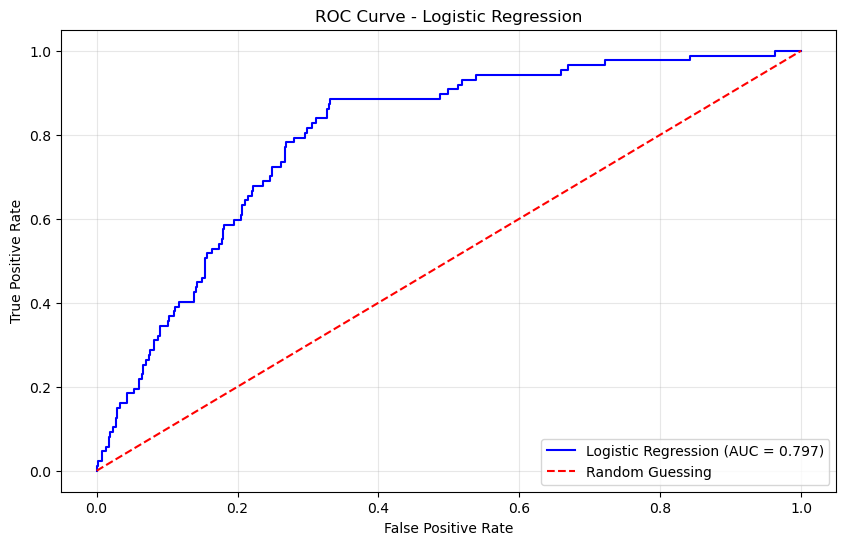

AUC Score for Logistic Regression: 0.797
Number of possible threshold points for Logistic Regression: 137


In [29]:
# Create ROC curve for the logistic regression model
from sklearn.metrics import roc_curve, roc_auc_score

def print_ROC_curve(y_true, y_proba, model_name):
    """
    Calculates and plots the ROC curve for a given model.

    Args:
        y_true: True labels.
        y_proba: Predicted probabilities for the positive class.
        model_name (str): Name of the model for plotting purposes.

    Returns:
        tuple: fpr, tpr, thresholds, auc_score
    """
    # Calculate the FPR, TPR, and thresholds for the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)

    # Calculate the AUC score
    auc_score = roc_auc_score(y_true, y_proba)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'{model_name} (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right')
    plt.show()

    # Print additional information about the ROC curve
    print(f"AUC Score for {model_name}: {auc_score:.3f}")
    # Print the number of threshold points
    print(f"Number of possible threshold points for {model_name}: {len(thresholds)}")

    return fpr, tpr, thresholds, auc_score

# Call the function for the logistic regression model
fpr, tpr, thresholds, auc_score = print_ROC_curve(y_test, y_pred_proba[:, 1], "Logistic Regression")

Considering that an AUC score of 0.5 is equivalent to random guessing in a classification task, the AUC of 0.797 is quite good already

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

def find_best_threshold_by_cost(y_true, y_proba, thresholds, cost_matrix):
    """
    Calculates the total cost for each threshold and identifies the best threshold
    that minimizes the total cost.

    Args:
        y_true: True labels.
        y_proba: Predicted probabilities for the positive class.
        thresholds (np.array): Array of thresholds obtained from roc_curve.
        cost_matrix (np.array): Cost matrix [[TN_cost, FP_cost], [FN_cost, TP_cost]].

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: DataFrame with cost and metrics for each threshold.
            - float: The best threshold value that minimizes total cost.
            - float: The minimum total cost achieved.
            - pd.DataFrame: DataFrame containing the top 5 thresholds with the lowest cost.
    """
    threshold_data = []

    # Iterate through each threshold obtained from roc_curve
    for threshold in thresholds:
        # Apply the current threshold to get predictions
        # Handle potential edge case where threshold might be > 1 (e.g., from roc_curve)
        if threshold > 1.0:
            continue # Skip thresholds that are not probabilities

        y_pred_threshold = (y_proba >= threshold).astype(int)

        # Calculate confusion matrix components for this threshold
        # Use labels=[0, 1] to ensure consistent order even if one class is missing in y_pred_threshold
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_threshold, labels=[0, 1]).ravel()

        # Calculate total cost for this threshold
        total_cost = (fp * cost_matrix[0, 1]) + (fn * cost_matrix[1, 0]) + (tp * cost_matrix[1, 1]) + (tn * cost_matrix[0, 0])

        # Calculate accuracy, precision, and recall
        accuracy_thresh = accuracy_score(y_true, y_pred_threshold)
        # Use zero_division=0 to handle cases where precision/recall might be undefined
        precision_thresh = precision_score(y_true, y_pred_threshold, zero_division=0)
        recall_thresh = recall_score(y_true, y_pred_threshold, zero_division=0)

        # Append results to the list
        threshold_data.append({
            'Threshold': threshold,
            'Total_Cost': total_cost,
            'Accuracy': accuracy_thresh,
            'Precision': precision_thresh,
            'Recall': recall_thresh,
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'TN': tn
        })

    # Create DataFrame from the results
    threshold_df = pd.DataFrame(threshold_data)

    # Find the top 5 thresholds with the lowest total cost
    top_5_lowest_cost_thresholds = threshold_df.nsmallest(5, 'Total_Cost')

    # Find the single best threshold based on minimum cost
    if not threshold_df.empty:
        best_threshold_by_cost_row = threshold_df.loc[threshold_df['Total_Cost'].idxmin()]
        best_threshold = best_threshold_by_cost_row['Threshold']
        min_total_cost = best_threshold_by_cost_row['Total_Cost']
    else:
        # Handle case where threshold_df might be empty (e.g., if all thresholds were > 1)
        best_threshold = None
        min_total_cost = float('inf')
        top_5_lowest_cost_thresholds = pd.DataFrame() # Return empty DataFrame

    return threshold_df, best_threshold, min_total_cost, top_5_lowest_cost_thresholds

cost_matrix = np.array([
    [0, 1],    # Costs for actual class 0 (TN=0, FP=1)
    [5.5, 1]   # Costs for actual class 1 (FN=5.5, TP=1)
])

# Calculate costs for each threshold using the new function
threshold_df, best_threshold, min_total_cost, top_5_lowest_cost_thresholds = find_best_threshold_by_cost(
    y_test, y_pred_proba[:, 1], thresholds, cost_matrix
)


# Display the top 5 thresholds
print("Top 5 Thresholds with the Lowest Total Cost:")
# Check if the DataFrame is not empty before displaying
if not top_5_lowest_cost_thresholds.empty:
    display(top_5_lowest_cost_thresholds)
else:
    print("No valid thresholds found to calculate costs.")

Top 5 Thresholds with the Lowest Total Cost:


,Threshold,Total_Cost,Accuracy,Precision,Recall,TP,FP,FN,TN
114,0.430291,302.0,0.700000,0.311741,0.885057,77,170,10,343
112,0.432162,305.5,0.700000,0.310204,0.873563,76,169,11,344
113,0.430697,306.5,0.698333,0.308943,0.873563,76,170,11,343
110,0.434053,309.0,0.700000,0.308642,0.862069,75,168,12,345
108,0.441008,310.0,0.710000,0.313305,0.839080,73,160,14,353


In [31]:
# Extract the single best threshold based on minimum cost
best_threshold_by_cost_row = threshold_df.loc[threshold_df['Total_Cost'].idxmin()]
best_threshold = best_threshold_by_cost_row['Threshold']
min_total_cost = best_threshold_by_cost_row['Total_Cost']

print(f"\nBest threshold based on minimum cost: {best_threshold:.6f}")
print(f"Minimum Total Cost achieved: {min_total_cost:.2f}")


Best threshold based on minimum cost: 0.430291
Minimum Total Cost achieved: 302.00


#### Step 7: Evaluate final Logistic Regression model

In [32]:
# Using the best threshold and the function show_correct_predictions from earlier
# and again evaluating whether correct and incorrect predictions are made as expected
# Note: it is not necessary to check for overfitting/underfitting again, as the model is the same
# Show correct predictions with the best threshold
correct_pred_df_best = show_correct_predictions(X_test, y_test, y_pred_proba[:, 1], threshold=best_threshold)

Threshold used for prediction: 0.430291
Number of correct predictions: 420
Percentage of correct predictions: 70.00%

Examples of correct predictions:


,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Actual_Churn,Probability_Positive_Class,Predicted_Churn
694,132,0,0,14.18,19.74,6.60,2.05,1,0,20.660198,0
2644,31,0,28,35.79,21.29,10.87,3.11,1,0,27.550747,0
596,80,0,0,25.26,17.92,9.17,2.70,2,0,42.135311,0
2423,95,0,0,26.84,22.07,10.35,3.78,0,0,21.746395,0
1389,115,0,0,34.03,20.82,8.59,2.38,1,0,41.281325,0
1011,205,0,24,29.89,13.18,8.13,2.11,2,0,22.764059,0
170,41,0,41,35.24,11.67,5.21,1.59,1,0,19.621614,0
2215,36,0,0,29.77,18.44,10.97,2.67,1,0,39.606432,0
811,161,0,0,17.92,18.26,10.06,2.11,0,0,14.579614,0
393,49,0,0,36.35,22.53,10.79,4.21,0,0,32.556760,0


In [33]:
# Show some examples of incorrect predictions with the best threshold
incorrect_pred_df_best = show_incorrect_predictions(X_test, y_test, y_pred_proba[:, 1], threshold=best_threshold)

Threshold used for prediction: 0.430291
Number of incorrect predictions: 180
Percentage of incorrect predictions: 30.00%

Examples of incorrect predictions:


,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Actual_Churn,Probability_Positive_Class,Predicted_Churn
484,67,0,0,25.93,21.45,8.34,1.32,2,0,50.611326,1
2078,86,0,0,33.01,16.47,8.64,2.51,3,0,62.393558,1
1338,105,0,0,36.04,19.26,8.71,2.40,3,0,66.234238,1
1192,97,1,0,24.43,23.21,8.02,2.94,0,0,68.617252,1
276,101,0,36,21.03,14.67,12.62,2.38,1,1,10.039158,0
1332,140,0,0,22.03,20.93,7.74,2.54,3,0,47.628208,1
2726,66,0,0,28.44,19.55,8.63,2.86,1,1,36.071812,0
146,89,1,0,21.35,18.11,8.18,1.46,1,0,77.100661,1
1870,79,0,0,36.31,19.97,10.33,2.38,2,0,57.722129,1
1219,129,0,0,24.43,25.31,9.57,3.08,4,0,63.198006,1


In [34]:
# Fuse together the correct and incorrect predictions DataFrames with the best threshold
# Concatenate the two DataFrames
final_pred_df = pd.concat([correct_pred_df_best, incorrect_pred_df_best], ignore_index=True)

# Print shape of final_pred_df
print(f"Shape of final_pred_df: {final_pred_df.shape}")
final_pred_df.head()

Shape of final_pred_df: (600, 11)


,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Actual_Churn,Probability_Positive_Class,Predicted_Churn
0,132,0,0,14.18,19.74,6.60,2.05,1,0,20.660198,0
1,31,0,28,35.79,21.29,10.87,3.11,1,0,27.550747,0
2,80,0,0,25.26,17.92,9.17,2.70,2,0,42.135311,0
3,95,0,0,26.84,22.07,10.35,3.78,0,0,21.746395,0
4,115,0,0,34.03,20.82,8.59,2.38,1,0,41.281325,0


The model seems to predict correct and incorrect predictions as expected.

In [35]:
# Create and display confusion matrix of the final predictions
final_conf_matrix = confusion_matrix(final_pred_df['Actual_Churn'], final_pred_df['Predicted_Churn'])

# Create a DataFrame to display the confusion matrix
final_conf_matrix_df = pd.DataFrame(final_conf_matrix, index=['Actual Not Churned', 'Actual Churned'], columns=['Predicted Not Churned', 'Predicted Churned'])

# Display the confusion matrix
final_conf_matrix_df

,Predicted Not Churned,Predicted Churned
Actual Not Churned,343,170
Actual Churned,10,77


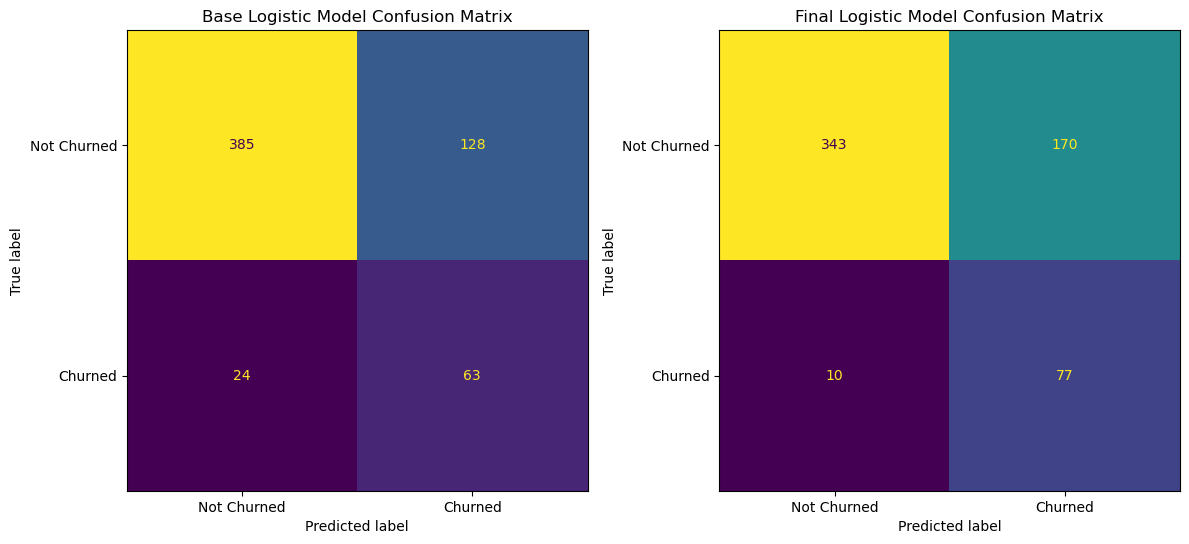

In [36]:
# Compare the confusion matrix of the final predictions with the one of the base model
# plotting them side by side
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


# Create confusion matrices for both models
conf_matrix_base = confusion_matrix(y_test, y_pred)

conf_matrix_final = confusion_matrix(final_pred_df['Actual_Churn'], final_pred_df['Predicted_Churn'])
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot confusion matrix for the base model
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_base, display_labels=['Not Churned', 'Churned']).plot(ax=axes[0], colorbar=False)
axes[0].set_title('Base Logistic Model Confusion Matrix')
# Plot confusion matrix for the final model
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_final, display_labels=['Not Churned', 'Churned']).plot(ax=axes[1], colorbar=False)
axes[1].set_title('Final Logistic Model Confusion Matrix')
plt.tight_layout()
plt.show()


As visible, the final logistic regression model with the lowest cost, despite having a worse overall prediction ability, manages to achieve a lower cost than the base model. It does this by correctly predicting more churners to churn, at the expense of incorrectly predicting a non-churners more incorrectly. Thereby it avoids the high cost of losing a customer, and trades it in for lower cost of retaining some customers that would not churn.

Adding this final model to the cost table:
| Model                                 | Total Cost | Cost Reduction (vs Baseline Scenario 1) |
|---------------------------------------|------------|-----------------------------------------|
| Scenario 1: Retain every customer     | 600.0      | 0.0%                                    |
| Scenario 2: Retain no customer        | 478.5      | 20.3%                                   |
| Base Logistic Regression Model        | 323.0      | 46.2%                                   |
| **Final Logistic Regression Model**   | **302.0**  | **49.7%**                               |

### Model 2: XGBoost

This model is chosen because while it is not as interpretable as a logistic regression, XGBoost is highly relevant for customer churn prediction because of its ability to handle structured data, detect complex nonlinear patterns, and deal with imbalanced datasets. Additionally, it has regularization capabilities and the importance of each feature can be determined to get an insight into why the model performs the way it does.

#### Step 1: Feature Selection

In [37]:
# For this model, we leave in all features, including the state, to give the model the best possible chance of predicting churn well.
# Transform state column into dummy variables (State and area code)
model2_df = pd.get_dummies(df, columns=['State'], drop_first=True)
model2_df = pd.get_dummies(model2_df, columns=['Area code'], drop_first=True)

# Create binary variables for categorical columns (International plan, voice mail plan and area code)
model2_df['International plan'] = model2_df['International plan'].map({'Yes': 1, 'No': 0})
model2_df['Voice mail plan'] = model2_df['Voice mail plan'].map({'Yes': 1, 'No': 0})

model2_df.head()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,...,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area code_415,Area code_510
0,64,0,0,0,261.9,113,44.52,148.1,99,12.59,...,False,False,False,False,False,False,False,False,False,False
1,139,1,1,31,203.5,82,34.60,200.3,72,17.03,...,True,False,False,False,False,False,False,False,False,True
2,93,0,0,0,190.7,114,32.42,218.2,111,18.55,...,False,False,False,True,False,False,False,False,False,True
3,136,0,0,0,163.4,83,27.78,249.3,119,21.19,...,False,False,False,False,False,False,False,False,True,False
4,16,1,0,0,110.0,91,18.70,147.3,75,12.52,...,False,False,False,False,False,False,False,False,True,False


In [38]:
# We will also not drop the columns that are perfectly linearly correlated because a random forest can better handle multicollinearity

In [39]:
# Also, again change Churn column from boolean to int with Churn = False as 0 and Churn = True as 1
model2_df['Churn'] = model2_df['Churn'].astype(int)
model2_df.head()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,...,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area code_415,Area code_510
0,64,0,0,0,261.9,113,44.52,148.1,99,12.59,...,False,False,False,False,False,False,False,False,False,False
1,139,1,1,31,203.5,82,34.60,200.3,72,17.03,...,True,False,False,False,False,False,False,False,False,True
2,93,0,0,0,190.7,114,32.42,218.2,111,18.55,...,False,False,False,True,False,False,False,False,False,True
3,136,0,0,0,163.4,83,27.78,249.3,119,21.19,...,False,False,False,False,False,False,False,False,True,False
4,16,1,0,0,110.0,91,18.70,147.3,75,12.52,...,False,False,False,False,False,False,False,False,True,False


In [40]:
# Finally, for this model we will add additional features
# Add total charge column
model2_df['Total charge'] = model2_df['Total day charge'] + model2_df['Total eve charge'] + model2_df['Total night charge'] + model2_df['Total intl charge']

# Add total minutes column
model2_df['Total minutes'] = model2_df['Total day minutes'] + model2_df['Total eve minutes'] + model2_df['Total night minutes'] + model2_df['Total intl minutes']

# Add total calls column
model2_df['Total calls'] = model2_df['Total day calls'] + model2_df['Total eve calls'] + model2_df['Total night calls'] + model2_df['Total intl calls']

# Add average call duration
model2_df['Average call duration'] = model2_df['Total minutes'] / model2_df['Total calls']

# Add Average Charge per Call
model2_df['Average charge per call'] = model2_df['Total charge'] / model2_df['Total calls']
model2_df.head()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,...,State_WI,State_WV,State_WY,Area code_415,Area code_510,Total charge,Total minutes,Total calls,Average call duration,Average charge per call
0,64,0,0,0,261.9,113,44.52,148.1,99,12.59,...,False,False,False,False,False,67.37,569.0,290,1.962069,0.232310
1,139,1,1,31,203.5,82,34.60,200.3,72,17.03,...,False,False,False,False,True,64.88,631.2,272,2.320588,0.238529
2,93,0,0,0,190.7,114,32.42,218.2,111,18.55,...,False,False,False,False,True,58.99,546.6,349,1.566189,0.169026
3,136,0,0,0,163.4,83,27.78,249.3,119,21.19,...,False,False,False,True,False,62.86,672.2,296,2.270946,0.212365
4,16,1,0,0,110.0,91,18.70,147.3,75,12.52,...,False,False,False,True,False,41.52,454.2,246,1.846341,0.168780


#### Step 2: Train-test split

In [41]:
# Use same train-test split as before
X_2 = model2_df.drop(['Churn'], axis=1)  # Features
y_2 = model2_df['Churn']  # Target variable

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=41, stratify=y_2)

# Check the shapes of the train and test sets
print(f"X_train_2 shape: {X_train_2.shape}")
print(f"X_test_2 shape: {X_test_2.shape}")
print(f"y_train_2 shape: {y_train_2.shape}")
print(f"y_test_2 shape: {y_test_2.shape}")

# Check the distribution of the target variable in train and test sets to ensure that stratify=y worked
print(f"Churn rate in training set: {y_train.mean() * 100:.2f}%")
print(f"Churn rate in test set: {y_test.mean() * 100:.2f}%")

X_train_2 shape: (2399, 74)
X_test_2 shape: (600, 74)
y_train_2 shape: (2399,)
y_test_2 shape: (600,)
Churn rate in training set: 14.51%
Churn rate in test set: 14.50%


#### Step 3: Hyperparameter tuning

In [42]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Create a pipeline that applies SMOTE bc of class imbalance and then trains a decision tree classifier
# The pipeline will be used to fit the model to the training data
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(random_state=42))
])

In [43]:
# Set up the hyperparameter grid for the decision tree classifier

param_grid = {
    'xgb__base_score': [0.5],         # Initial prediction score for all instances, lower values predict less churn
    'xgb__booster': ['gbtree'],       # Algorithm to use - tree-based, linear model
    'xgb__colsample_bylevel': [1.0],  # Subsample ratio of columns for each level within a tree
    'xgb__colsample_bytree': [1.0],   # Subsample ratio of columns when constructing each tree
    'xgb__gamma': [0, 0.1],           # Minimum loss reduction required for further partition on a leaf node
    'xgb__n_estimators': [50, 100],   # Number of trees to build (more trees = better performance but slower)
    'xgb__max_depth': [3, 4, 5],      # Maximum depth of a tree (controls complexity)
    'xgb__learning_rate': [0.9, 0.1],   # Step size shrinkage to prevent overfitting
    'xgb__min_child_weight': [1, 2],        # Minimum sum of instance weight needed in a child
    'xgb__objective': ['binary:logistic'],   # Defines the loss function (binary classification with logistic)
    'xgb__random_state': [42],              # Random number seed for reproducibility
    'xgb__reg_alpha': [0, 0.5, 2.0],        # L1 regularization on weights (prevents overfitting)
    'xgb__reg_lambda': [1, 2, 10],           # L2 regularization on weights (prevents overfitting)
    'xgb__subsample': [1]                   # Subsample ratio of training instances (1 = use all samples)
}

In [44]:
from sklearn.model_selection import GridSearchCV

# Set up stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up the grid search with the pipeline, parameter grid, and cross-validation
# scoring should be based on the total cost matrix defined earlier
# Define a custom scoring function based on the cost matrix
from sklearn.metrics import make_scorer

# Create a custom scorer using the make_scorer function and the globally defined total_cost_scorer
cost_function = make_scorer(total_cost_scorer, greater_is_better=False, **{'cost_matrix': cost_matrix})

# Set up the grid search with the pipeline, parameter grid, and cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring=cost_function,  # Use cost function as the scoring metric
    n_jobs=-1,  # Use all available CPU cores for processing
    verbose=1,  # Show final output of the grid search
)

# Fit the grid search to the training data
grid_search.fit(X_train_2, y_train_2)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      featu...
                         'xgb__max_depth': [3, 4, 5],
                         'xgb__min_child_weight': [1, 2],
                         'xgb__n_estimators': [50, 100],
                         'xgb__objective': ['binary:logistic'],
                         'xgb__random_state': [42],
                         'xgb__reg_alpha': [0, 0.5, 2.0],
                         'xgb__reg_lambda': [1, 2, 10], 'xgb__subsample': [1]},
             scoring=make_scorer(total_cost_scorer, greater_is_better=False, response_method='predict', cost_matrix=[[0.  1. ]
 [5.5 1. ]]),
             verbose=1)

In [45]:
# Output best parameters and cross-validation accuracy
print("Best Hyperparameters:", grid_search.best_params_)

# Output the lowest cross-validation cost achieved
# Note: The negative sign is used because the scoring function returns negative costs
print("Lowest CV Total Cost: ", -grid_search.best_score_)

Best Hyperparameters: {'xgb__base_score': 0.5, 'xgb__booster': 'gbtree', 'xgb__colsample_bylevel': 1.0, 'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 100, 'xgb__objective': 'binary:logistic', 'xgb__random_state': 42, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 1, 'xgb__subsample': 1}
Lowest CV Total Cost:  120.3


#### Step 4: Evaluating the Model

In [46]:
# Evaluate on the test set using the best found model
best_xgb_model = grid_search.best_estimator_
y_pred_2 = best_xgb_model.predict(X_test_2)

# Evaluate the model using the custom evaluation function
test_metrics_xgb, train_metrics_xgb = evaluate_model(
    best_xgb_model, X_train_2, y_train_2, X_test_2, y_test_2, "XGBoost Classifier", cost_matrix)


--- Evaluation for XGBoost Classifier ---

Test Set:
Confusion Matrix:
  TN: 510, FP: 3
  FN: 13, TP: 74
Accuracy: 97.33%
Recall: 85.06%
Precision: 96.10%

Train Set:
Confusion Matrix:
  TN: 2050, FP: 1
  FN: 39, TP: 309
Accuracy: 98.33%
Recall: 88.79%
Precision: 99.68%

Test Set Total Cost: 148.50
------------------------------------------


As visible, the base XGBoost model has a total cost of 150.5 units for the test split, which again is calculated as:

**Total Cost**
$$
\text{Total Cost} = (1 \times \text{FP}) + (5.5 \times \text{FN}) + (1 \times \text{TP}) + \cancel{(0 \times \text{TN})}
$$

$$
\text{Total Cost} = (1 \times 5) + (5.5 \times 13) + (1 \times 74)
$$

Like for the logistic regression, before we compare this model to the baseline scenarios, first we need to evaluate the model's outputs.
We do this by looking at three things
1. Check the model fit to ensure it is not overfitting/underfitting
2. Look at some correct predictions (predictions of churners as churners or non-churners as non-churners) to ensure these are accurate
3. Look at some incorrect predictions (predictions of churners as non-churners or non-churners as churners) to ensure these are accurate

In [47]:
# Check for overfitting/underfitting of the XGBoost model
check_model_fit(train_metrics_xgb, test_metrics_xgb, "XGBoost Classifier")


--- Fit Check for XGBoost Classifier ---
Model fit appears reasonable (no significant overfitting or underfitting detected based on current thresholds)
  Reason: Performance differences between train and test sets are within the 10% threshold,
          and performance metrics are generally above the 70% underfitting threshold.
  Accuracy difference: 1.00%
  Recall difference: 3.74%
  Precision difference: 3.57%
-----------------------------------------


In [48]:
# Show some examples of correct predictions using correct_pred_df function
correct_pred_df_xgb = show_correct_predictions(X_test_2, y_test_2, best_xgb_model.predict_proba(X_test_2)[:, 1])

Threshold used for prediction: default (0.5)
Number of correct predictions: 584
Percentage of correct predictions: 97.33%

Examples of correct predictions:


,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,...,Area code_415,Area code_510,Total charge,Total minutes,Total calls,Average call duration,Average charge per call,Actual_Churn,Probability_Positive_Class,Predicted_Churn
2314,94,0,0,0,108.0,79,18.36,241.9,152,20.56,...,True,False,53.07,612.4,326,1.878528,0.162791,0,16.461416,0
412,105,0,0,0,102.8,74,17.48,281.7,125,23.94,...,True,False,55.24,625.8,317,1.974132,0.174259,0,7.486309,0
2612,43,1,0,0,251.5,105,42.76,212.8,104,18.09,...,True,False,70.46,631.4,280,2.255000,0.251643,0,4.822292,0
2064,158,0,0,0,205.2,97,34.88,240.6,77,20.45,...,False,True,62.81,539.9,294,1.836395,0.213639,0,7.716352,0
1312,170,1,0,0,259.9,68,44.18,245.0,122,20.83,...,False,True,73.33,647.7,314,2.062739,0.233535,0,12.387973,0
1360,86,0,0,0,124.1,82,21.10,202.6,120,17.22,...,False,True,53.16,623.0,329,1.893617,0.161581,0,2.333616,0
1103,101,0,0,0,217.7,118,37.01,231.7,128,19.69,...,True,False,65.04,634.7,374,1.697059,0.173904,0,6.500860,0
1319,128,0,0,0,216.0,111,36.72,153.7,115,13.06,...,True,False,63.43,609.4,304,2.004605,0.208651,0,7.516521,0
2545,37,1,1,39,149.7,122,25.45,211.1,75,17.94,...,False,False,51.01,484.3,291,1.664261,0.175292,0,1.857644,0
653,97,0,1,28,202.3,97,34.39,69.2,84,5.88,...,True,False,53.67,535.8,248,2.160484,0.216411,0,5.583154,0


In [49]:
# Show some examples of incorrect predictions using incorrect_pred_df function
incorrect_pred_df_xgb = show_incorrect_predictions(X_test_2, y_test_2, best_xgb_model.predict_proba(X_test_2)[:, 1])

Threshold used for prediction: default (0.5)
Number of incorrect predictions: 16
Percentage of incorrect predictions: 2.67%

Examples of incorrect predictions:


,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,...,Area code_415,Area code_510,Total charge,Total minutes,Total calls,Average call duration,Average charge per call,Actual_Churn,Probability_Positive_Class,Predicted_Churn
707,137,0,0,0,110.5,79,18.79,223.2,111,18.97,...,False,True,48.23,513.7,257,1.998833,0.187665,0,58.863129,1
2753,121,0,0,0,144.8,126,24.62,200.6,82,17.05,...,True,False,54.66,567.5,298,1.904362,0.183423,1,18.132057,0
276,101,0,1,36,123.7,125,21.03,172.6,106,14.67,...,True,False,50.70,585.6,362,1.617680,0.140055,1,4.933971,0
223,103,0,1,18,149.9,84,25.48,170.9,84,14.53,...,True,False,50.84,503.8,287,1.755401,0.177143,1,6.156115,0
2932,159,0,0,0,189.1,105,32.15,246.1,147,20.92,...,True,False,66.77,687.6,363,1.894215,0.183939,1,3.537683,0
1372,67,0,0,0,260.4,107,44.27,208.2,104,17.70,...,False,False,74.03,686.5,328,2.092988,0.225701,0,99.081902,1
1890,40,0,1,31,224.7,69,38.20,134.5,81,11.43,...,False,False,57.07,487.0,259,1.880309,0.220347,1,2.669762,0
1396,105,0,0,0,226.9,106,38.57,182.2,77,15.49,...,True,False,66.37,624.6,292,2.139041,0.227295,1,37.043289,0
742,77,0,0,0,233.8,104,39.75,266.5,94,22.65,...,False,True,74.02,720.6,305,2.362623,0.242689,0,99.399345,1
2660,58,0,0,0,112.2,95,19.07,209.6,108,17.82,...,False,True,52.38,596.6,282,2.115603,0.185745,1,15.616047,0


Seeing as the model does not overfit and both the correct and incorrect predictions seem accurate, we can safely compare this model to the other models:

| Model                                 | Total Cost | Cost Reduction (vs Baseline Scenario 1) |
|---------------------------------------|------------|-----------------------------------------|
| Scenario 1: Retain every customer     | 600.0      | 0.0%                                    |
| Scenario 2: Retain no customer        | 478.5      | 20.3%                                   |
| Base Logistic Regression Model        | 323.0      | 46.2%                                   |
| Final Logistic Regression Model       | 302.0      | 49.7%                                   |
| **Base XGBoost Regression Model**    | **148.5**  | **75.3%**                                |


This total cost of **148.5** units now serves as the cost to beat for future models.

This model is very good, much better than the best logistic regression model even. However, there is still potential to optimize it further by choosing a better decision threshold.

We can again find a better decision threshold by examining the ROC curve to balance recall and false positive rate, then choosing a threshold that produces a lower total cost.

#### Step 5: Choosing the right decision threshold

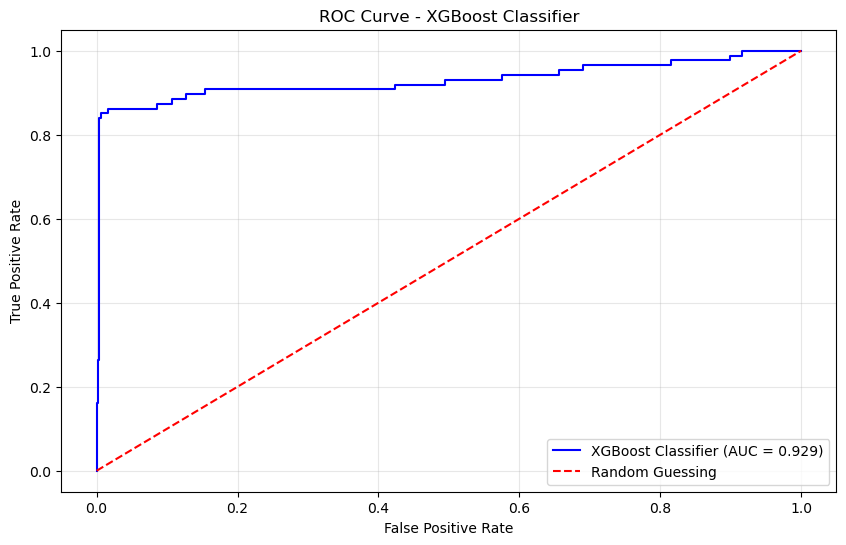

AUC Score for XGBoost Classifier: 0.929
Number of possible threshold points for XGBoost Classifier: 36


In [50]:
# Use the function print_ROC_curve to create the ROC curve for the XGBoost model
fpr_2, tpr_2, thresholds_2, auc_score_2 = print_ROC_curve(y_test_2, best_xgb_model.predict_proba(X_test_2)[:, 1], "XGBoost Classifier")

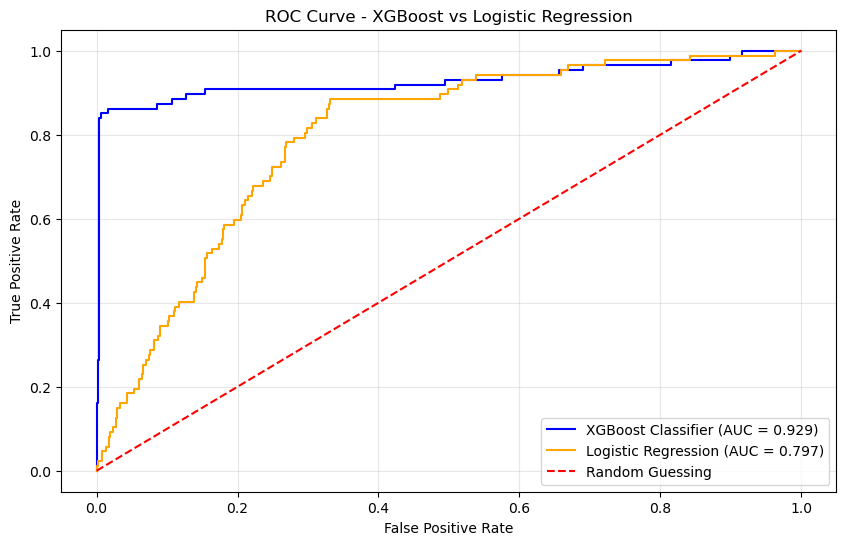

In [51]:
# Show the logistic regression ROC curve for comparison
# Create a figure to plot both ROC curves
plt.figure(figsize=(10, 6))
# Plot the ROC curve for the XGBoost model
plt.plot(fpr_2, tpr_2, color='blue', label=f'XGBoost Classifier (AUC = {auc_score_2:.3f})')
# Plot the ROC curve for the Logistic Regression model
plt.plot(fpr, tpr, color='orange', label=f'Logistic Regression (AUC = {auc_score:.3f})')
# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost vs Logistic Regression')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.show()

The XGBoost classifier with its AUC of 0.926 is very good and as expected, better than the logistic regression based on its AUC. However, at a low threshold, the logistic regression model performs a bit better. This does not seem to matter though, considering that the base XGBoost model had a significantly lower cost than the final logistic regression model already. We now look if there is an even better model by optimizing the decision threshold of the XGBoost model.

In [52]:
# find best decision threshold for the XGBoost model using the function find_best_threshold_by_cost
threshold_df_xgb, best_threshold_xgb, min_total_cost_xgb, top_5_lowest_cost_thresholds_xgb = find_best_threshold_by_cost(
    y_test_2, best_xgb_model.predict_proba(X_test_2)[:, 1], thresholds_2, cost_matrix
)
# Display the top 5 thresholds for the XGBoost model
print("Top 5 Thresholds with the Lowest Total Cost for XGBoost:")
# Check if the DataFrame is not empty before displaying
if not top_5_lowest_cost_thresholds_xgb.empty:
    display(top_5_lowest_cost_thresholds_xgb)
else:
    print("No valid thresholds found to calculate costs.")

Top 5 Thresholds with the Lowest Total Cost for XGBoost:


,Threshold,Total_Cost,Accuracy,Precision,Recall,TP,FP,FN,TN
7,0.549977,148.5,0.973333,0.961039,0.850575,74,3,13,510
9,0.370433,149.0,0.966667,0.903614,0.862069,75,8,12,505
5,0.799798,152.0,0.973333,0.973333,0.839080,73,2,14,511
6,0.588631,153.0,0.971667,0.960526,0.839080,73,3,14,510
8,0.374065,153.5,0.965000,0.902439,0.850575,74,8,13,505


In [53]:
# Extract the single best threshold based on minimum cost for the XGBoost model
best_threshold_xgb_row = threshold_df_xgb.loc[threshold_df_xgb['Total_Cost'].idxmin()]
best_threshold_xgb = best_threshold_xgb_row['Threshold']
min_total_cost_xgb = best_threshold_xgb_row['Total_Cost']

print(f"\nBest threshold based on minimum cost: {best_threshold_xgb:.6f}")
print(f"Minimum Total Cost achieved: {min_total_cost_xgb:.2f}")


Best threshold based on minimum cost: 0.549977
Minimum Total Cost achieved: 148.50


There is no further decrease in cost by changing the decision threshold. Therefore, the base XGBoost model is also the final XGBoost model and remains the best model for our use case.

Therefore the final cost table of all models is:
| Model                                 | Total Cost | Cost Reduction (vs Baseline Scenario 1) |
|---------------------------------------|------------|-----------------------------------------|
| Scenario 1: Retain every customer     | 600.0      | 0.0%                                    |
| Scenario 2: Retain no customer        | 478.5      | 20.3%                                   |
| Base Logistic Regression Model        | 323.0      | 46.2%                                   |
| Final Logistic Regression Model       | 302.0      | 49.7%                                   |
| **Final XGBoost Regression Model**    | **148.5**  | **75.3%**                               |

We were able to decrease the cost for the company by over a factor of 4 or by 75% from 600 units to 148.5 units using our best model.

## Saving the model into a pickle file

In [54]:
# Load initial dataset
df = pd.read_csv('0_churn_dataset.csv')

# Identify numerical and categorical columns
df.dtypes

State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [55]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import pickle

# Save numerical columns to a list
numerical_columns = ['Account length', 'Area code', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']

# Save categorical columns to a list
categorical_columns = ['State', 'International plan', 'Voice mail plan']

# Convert Churn from boolean to integer (0 for False, 1 for True)
df['Churn'] = df['Churn'].astype(int)

# Split the data into features and target variable
X_save = df.drop('Churn', axis=1)
Y_save = df['Churn']

# Define function to perform feature selection steps
def feature_engineering(X_save):
    # Add total charge column
    X_save['Total charge'] = X_save['Total day charge'] + X_save['Total eve charge'] + X_save['Total night charge'] + X_save['Total intl charge']
    # Add total minutes column
    X_save['Total minutes'] = X_save['Total day minutes'] + X_save['Total eve minutes'] + X_save['Total night minutes'] + X_save['Total intl minutes']
    # Add total calls column
    X_save['Total calls'] = X_save['Total day calls'] + X_save['Total eve calls'] + X_save['Total night calls'] + X_save['Total intl calls']
    # Add average call duration
    X_save['Average call duration'] = X_save['Total minutes'] / X_save['Total calls']
    # Add Average Charge per Call
    X_save['Average charge per call'] = X_save['Total charge'] / X_save['Total calls']

    return X_save

# Apply FunctionTransformer to apply the feature engineering function
feature_transformer = FunctionTransformer(feature_engineering)

# Handle NaN values in the dataset
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Replace NaN with median
    ('scaler', StandardScaler())  # Scale the numerical data
])

# Handle categorical values in the dataset
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),  # Replace NaN with 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical data
])

# 3 Combine both transformations into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Create the full pipeline with preprocessing + feature engineering + model
preprocessing_pipeline = Pipeline([
    ('feature_engineering', feature_transformer), 
    ('preprocessor', preprocessor),
])

# Apply preprocessing transformations
X_transformed = preprocessing_pipeline.fit_transform(X_save)

# Train-test split
X_train_save, X_test_save, Y_train_save, Y_test_save = train_test_split(X_transformed, Y_save, test_size=0.20, random_state=42)

# Train **XGBoost** Model
xgb_model = best_xgb_model
xgb_model.fit(X_train_save, Y_train_save)

# Save **Preprocessing + Feature Engineering Together**
with open("2_preprocessor.pkl", "wb") as file:
    pickle.dump(preprocessing_pipeline, file)

# Save **XGBoost Model** as Pickle
with open("3_best_model.pkl", "wb") as file:
    pickle.dump(xgb_model, file)  # Saving XGBClassifier using Pickle

print("Preprocessing pipeline (feature engineering + transformations) and XGBoost model saved successfully!")

Preprocessing pipeline (feature engineering + transformations) and XGBoost model saved successfully!


In [56]:
#Finally create a requirements.txt file with all necessary libraries
!pip freeze > requirements.txt